In [83]:
# model
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as fn
import torchvision
import cv2 as cv
import time
from matplotlib import pyplot as plt
from torchsummary import summary

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import os
from pathlib import Path
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


In [10]:
class View(nn.Module):
    
    def __init__(self, *shape): 
        super(View, self).__init__() 
        self.shape = shape
        
    def forward(self, x):
        return x.view(x.shape[0], *self.shape) # x.shape = [batch_size, channel, width, height]

In [11]:
class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )

        self.shortcut = nn.Sequential()

        self.relu = nn.ReLU()

        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels*BottleNeck.expansion)
            )
            
    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10, init_weights=True):
        super().__init__()

        self.in_channels=64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # weights inittialization
        if init_weights:
            self._initialize_weights()

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion

        return nn.Sequential(*layers)

    def forward(self,x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        x = self.conv3_x(output)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    # define weight initialization function
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [7]:
Model = ResNet(BottleNeck, [3,4,6,3])
Model = Model.to(device)

In [8]:
summary(Model, input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [55]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [59]:

from __future__ import print_function, division
import random
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import cv2
from torchvision import transforms, utils

# Ignore warnings
import warnings

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated


class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None,rgb = True):
        """
        Args:
            csv_file (s ring): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        #self.images = np.zeros()
        self.root_dir = root_dir
        print(len(self.landmarks_frame))
        '''
        for i in xrange(len(self.landmarks_frame)):
            img_name = os.path.join(self.root_dir, self.landmarks_frame.ix[i, 0])
            image = cv2.imread(img_name)
            self.img_list.append(image)
        '''
        self.transform = transform
        self.rgb = rgb

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = cv2.imread(img_name)
        if self.rgb:
            image = image[...,::-1]
        landmarks = self.landmarks_frame.iloc[idx, 1:].to_numpy().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample


class Rescale(object):
    """Rescale the image in a sample to a given size.
    Args:
        output_size (tuple or tuple): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        #img = transform.resize(image, (new_h, new_w))
        img = cv2.resize(image,(new_w,new_h))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.
    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}

class SmartRandomCrop(object):
    """Crop randomly the image in a sample.
    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, zoom_scale = 3):
        assert isinstance(zoom_scale, (int, float))
        self.zoom_scale = zoom_scale
    def get_random_rect(self,min_x,min_y,max_x,max_y,w,h):
        rec_w = max_x  - min_x
        rec_h = max_y  - min_y
        scale = (self.zoom_scale-1)/2.0
        b_min_x = min_x - rec_w*scale if min_x - rec_w*scale >0 else 0
        b_min_y = min_y - rec_h*scale if min_y - rec_h*scale >0 else 0
        b_max_x = max_x + rec_w*scale if max_x + rec_w*scale <w else w
        b_max_y = max_y + rec_h*scale if max_y + rec_h*scale <h else h
        #r_min_x = np.random.randint(int(b_min_x),int(min_x)) if b_min_x<min_x else int(min_x)
        #r_min_y = np.random.randint(int(b_min_y),int(min_y)) if b_min_y<min_y else int(min_y)
        #r_max_x = np.random.randint(int(max_x),int(b_max_x)) if b_max_x > max_x else int(max_x)
        #r_max_y = np.random.randint(int(max_y),int(b_max_y)) if b_max_y > max_y else int(max_y)
        return b_min_x,b_min_y,b_max_x,b_max_y

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        min_xy  = np.min(landmarks,axis= 0)
        max_xy  = np.max(landmarks,axis= 0)
        min_x,min_y,max_x,max_y = self.get_random_rect(min_xy[0],min_xy[1],max_xy[0],max_xy[1],w,h)
        image = image[int(min_y): int(max_y),
                int(min_x):int(max_x)]

        landmarks = landmarks - [min_x, min_y]

        return {'image': image, 'landmarks': landmarks}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self,image_size):
        self.image_size = image_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        landmarks =landmarks.reshape(-1,1)
        return {'image': torch.from_numpy(image).float().div(255),
                'landmarks': torch.from_numpy(landmarks).float().div(self.image_size)}

class RandomFlip(object):
    def __call__(self, sample):
        image = sample['image']
        landmarks = sample['landmarks']
        if random.random()<0.5:
            image = cv2.flip(image,0)
            landmarks[:,0] = image.shape[1]-landmarks[:,0]
        return {'image': image, 'landmarks': landmarks}

class Normalize(object):
    def __init__(self,mean,std):
        self.mean = mean
        self.std = std
    def __call__(self, sample):
        image = sample['image']
        for t, m, s in zip(image, self.mean, self.std):
            t.sub_(m).div_(s)
        sample['image'] = image
        return sample

class SwapChannels(object):
    """Transforms a tensorized image by swapping the channels in the order
     specified in the swap tuple.
    Args:
        swaps (int triple): final order of channels
            eg: (2, 1, 0)
    """

    def __init__(self, swaps):
        self.swaps = swaps

    def __call__(self, image):
        """
        Args:
            image (Tensor): image tensor to be transformed
        Return:
            a tensor with channels swapped according to swap
        """
        # if torch.is_tensor(image):
        #     image = image.data.cpu().numpy()
        # else:
        #     image = np.array(image)
        image = image[:, :, self.swaps]
        return image
class RandomLightingNoise(object):
    def __init__(self):
        self.perms = ((0, 1, 2), (0, 2, 1),
                      (1, 0, 2), (1, 2, 0),
                      (2, 0, 1), (2, 1, 0))

    def __call__(self, sample):
        image = sample['image']
        if random.randint(0,2):
            swap = self.perms[random.randint(0,len(self.perms)-1)]
            shuffle = SwapChannels(swap)  # shuffle channels
            image = shuffle(image)
            sample['image'] = image
        return sample

class RandomContrast(object):
    def __init__(self, lower=0.5, upper=1.5):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    # expects float image
    def __call__(self, sample):
        if random.randint(0,2):
            image = sample['image']
            alpha = random.uniform(self.lower, self.upper)
            image *= alpha
            sample['image'] = image
        return sample

class RandomBrightness(object):
    def __init__(self, delta=32):
        assert delta >= 0.0
        assert delta <= 255.0
        self.delta = delta

    def __call__(self, sample):
        image = sample['image']
        if random.randint(0,2):
            delta = random.uniform(-self.delta, self.delta)
            np.add(image, delta, out=image, casting="unsafe")
            #image += delta
            sample['image'] = image
        return sample




######################################################################
# Compose transforms
# ~~~~~~~~~~~~~~~~~~
#
# Now, we apply the transforms on an sample.
#
# Let's say we want to rescale the shorter side of the image to 256 and
# then randomly crop a square of size 224 from it. i.e, we want to compose
# ``Rescale`` and ``RandomCrop`` transforms.
# ``torchvision.transforms.Compose`` is a simple callable class which allows us
# to do this.
#

'''
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])
# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)
plt.show()
'''

'\nscale = Rescale(256)\ncrop = RandomCrop(128)\ncomposed = transforms.Compose([Rescale(256),\n                               RandomCrop(224)])\n# Apply each of the above transforms on sample.\nfig = plt.figure()\nsample = face_dataset[65]\nfor i, tsfrm in enumerate([scale, crop, composed]):\n    transformed_sample = tsfrm(sample)\n    ax = plt.subplot(1, 3, i + 1)\n    plt.tight_layout()\n    ax.set_title(type(tsfrm).__name__)\n    show_landmarks(**transformed_sample)\nplt.show()\n'

[245. 259.]
[55. 80.]
Image name: T_Boone_Pickens_11.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 55. 131.]
 [ 60. 152.]
 [ 65. 178.]
 [ 76. 194.]]
770
0 (256, 256, 3) (68, 2)


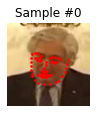

1 (256, 256, 3) (68, 2)


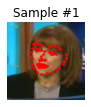

2 (256, 256, 3) (68, 2)


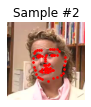

3 (256, 256, 3) (68, 2)


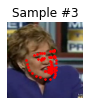

In [61]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


# Ignore warnings
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated
landmarks_frame = pd.read_csv('input/test_frames_keypoints.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].to_numpy().astype('float')
landmarks = landmarks.reshape(-1, 2)
max_xy = np.max(landmarks,axis=0)
min_xy = np.min(landmarks,axis=0)
print(max_xy)
print(min_xy)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))
face_dataset = FaceLandmarksDataset(csv_file='input/test_frames_keypoints.csv',
                                    root_dir='input/training/')

fig = plt.figure()
crop = SmartRandomCrop()
scale = Rescale((256,256))
composed = transforms.Compose([SmartRandomCrop(),])

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    sample = crop(sample)
    sample = scale(sample)

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

In [64]:
RGB_MEAN = [ 0.485, 0.456, 0.406 ]
RGB_STD = [ 0.229, 0.224, 0.225 ]

In [65]:
train_transform = transforms.Compose([
    transforms.Scale(256),  # smaller side resized
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = RGB_MEAN,
                        std = RGB_STD),
])

C:\Users\alscj\anaconda3\envs\Torch\lib\site-packages\torchvision\transforms\transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [66]:
val_transform = transforms.Compose([
    transforms.Scale((224,224)), 
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = RGB_MEAN,
                         std = RGB_STD),
])


In [74]:
train_data = FaceLandmarksDataset(csv_file = 'input/training_frames_keypoints.csv',transform=train_transform,root_dir='input/training/')
trainloader = data.DataLoader(train_data, batch_size=32, shuffle=True)

3462


In [75]:
test_data = FaceLandmarksDataset(csv_file = 'input/test_frames_keypoints.csv', transform=val_transform, root_dir='input/test/')
testloader = data.DataLoader(test_data, batch_size=32, shuffle=True, )

770


In [78]:
model = ResNet(BottleNeck, [3,4,6,3])
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2_x): Sequential(
    (0): BottleNeck(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
     

In [80]:
loss_fn = nn.SmoothL1Loss().cuda()
optimizer = optim.SGD(model.parameters(), lr=0.001)
use_cuda = torch.cuda.is_available()

In [81]:
def adjust_learning_rate(optimizer, epoch):
    global state
    if epoch in args.schedule:
        state['lr'] *= args.gamma
        for param_group in optimizer.param_groups:
            param_group['lr'] = state['lr']

In [98]:
import time
def train(trainloader, model, loss_fn, optimizer, epoch, use_cuda):
    model.train()

    for batch_idx, batch_data in enumerate(trainloader):
        # measure data loading time
        inputs = batch_data['image']
        targets = batch_data['landmarks']
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        #nms= normalizedME(outputs.data,targets.data,64,64)
        losses.update(loss.data[0], inputs.size(0))
        #NormMS.update(nms[0], inputs.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return (losses.avg,0)

In [99]:
def test(testloader, model, criterion, epoch, use_cuda):
    global best_acc

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar('Processing', max=len(testloader))
    for batch_idx, batch_data in enumerate(testloader):
        # measure data loading time
        data_time.update(time.time() - end)

        inputs = batch_data['image']
        targets = batch_data['landmarks']
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        losses.update(loss.data[0], inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} '.format(
                    batch=batch_idx + 1,
                    size=len(testloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return (losses.avg,0)

In [100]:
def save_checkpoint(state, is_best, checkpoint='checkpoint', filename='checkpoint.pth.tar'):
    filepath = os.path.join(checkpoint, filename)
    torch.save(state, filepath)
    if is_best:
        shutil.copyfile(filepath, os.path.join(checkpoint, 'model_best.pth.tar'))

def adjust_learning_rate(optimizer, epoch):
    global state
    if epoch in args.schedule:
        state['lr'] *= args.gamma
        for param_group in optimizer.param_groups:
            param_group['lr'] = state['lr']



In [45]:

fpath = "/input/"
train_df['fnames'] = train_df['fnames'].apply(lambda y: fpath +"training/" + y )
train_df.head()

,fnames,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,/input/training//input/training//input/trainin...,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,/input/training//input/training//input/trainin...,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,/input/training//input/training//input/trainin...,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,/input/training//input/training//input/trainin...,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,/input/training//input/training//input/trainin...,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [46]:
test_df['fnames'] = test_df['fnames'].apply(lambda y: fpath +"test/" + y )
test_df.head()

,fnames,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,/input/test//input/test/../input/test/Luis_Fon...,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,/input/test//input/test/../input/test/Lincoln_...,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,/input/test//input/test/../input/test/Valerie_...,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,/input/test//input/test/../input/test/Angelo_R...,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,/input/test//input/test/../input/test/Kristen_...,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [50]:
row = train_df.iloc[0,:]
img = cv.imread(row[0])
plt.show(img)

In [48]:
cv.imshow('Test image',img)
cv.waitKey(0)

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-kh7iq4w7\opencv\modules\highgui\src\window.cpp:376: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


In [32]:
import matplotlib.pyplot as plt
import numpy as np
import config
def valid_keypoints_plot(image, outputs, orig_keypoints, epoch):
    """
    This function plots the regressed (predicted) keypoints and the actual 
    keypoints after each validation epoch for one image in the batch.
    """
    # detach the image, keypoints, and output tensors from GPU to CPU
    image = image.detach().cpu()
    outputs = outputs.detach().cpu().numpy()
    orig_keypoints = orig_keypoints.detach().cpu().numpy()
    # just get a single datapoint from each batch
    img = image[0]
    output_keypoint = outputs[0]
    orig_keypoint = orig_keypoints[0]
    img = np.array(img, dtype='float32')
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    
    output_keypoint = output_keypoint.reshape(-1, 2)
    orig_keypoint = orig_keypoint.reshape(-1, 2)
    for p in range(output_keypoint.shape[0]):
        plt.plot(output_keypoint[p, 0], output_keypoint[p, 1], 'r.')
        plt.plot(orig_keypoint[p, 0], orig_keypoint[p, 1], 'b.')
    plt.savefig(f"{config.OUTPUT_PATH}/val_epoch_{epoch}.png")
    plt.close()

In [ ]:
print(img)